In [2]:
import sympy as sp
from sympy import *
from sympy.solvers import solve
import numpy as np
from numpy import linalg
import scipy.stats as scs
import matplotlib.pyplot as plt

In [232]:
# Example of finding jacobian at a specific point 
# from https://stackoverflow.com/questions/26669706/evaluating-jacobian-at-specific-points-using-sympy
x,y = sp.symbols('x,y', real = True)
f1 = -y
f2 = x - 3*y*(1-x**2)
F = sp.Matrix([f1,f2])
F.jacobian([x,y])
F.jacobian([x,y]).subs(([(x, 0),(y,0)])) #subs evaluates an expression at a point

Matrix([
[0, -1],
[1, -3]])

In [4]:
# declare symbols (which will be differentiated by)
u1,u2,bu,x1, x2, bx, y1, y2, by, r1,r2,p = sp.symbols('u1,u2,bu,x1,x2,bx,y1,y2,by,r1,r2,p', real = True)

#TO-DO: get actual possible parameter values

def Kfun(d, norm):
    # if d = -1, that means K = 1
    if d == -1:
        return(1)
    K = norm.cdf(d) - norm.cdf(-d)
    return(K)
def pcfun(d, norm):
    if d == -1:
        return(0)
    pc = 1 - norm.cdf(d)
    return(pc)
def pwfun(d,norm):
    if d == -1:
        return(0)
    pw = norm.cdf(-d)
    return(pw)



def EqSys(d,ddelta,D,Deps, mu = 0.1, sigma = 1):
    dprime = d + deltad
    Dprime = D + Deps
    norm = scs.norm(mu,sigma)
    u = u1 + u2 + bu
    x = x1 + x2 + bx
    y = y1 + y2 + by
    p1 = u1 + x1 + y1
    p2 = u2 + x2 + y2
    phi = p*(1 - p)*(2*p -1)

    
    Wfu1 = u *(Kfun(d,norm)*(p1 + D*phi.subs([(p,p1)])) + pcfun(d,norm))*(1 + r1)
    Wfu2 = u * (Kfun(d,norm)*(p2 + D*phi.subs([(p,p2)])) + pcfun(d,norm))*(1 + r2)
    Wgu = u*(Kfun(d,norm)*(1 - p1 - p2 - D*phi.subs([(p,p1+p2)])) + pwfun(d,norm))
    Wfx1 = x *(Kfun(dprime,norm)*(p1 + D*phi.subs([(p,p1)])) + pcfun(dprime,norm))*(1 + r1)
    Wfx2 = x * (Kfun(dprime,norm)*(p2 + D*phi.subs([(p,p2)])) + pcfun(dprime,norm))*(1 + r2)
    Wgx = x*(Kfun(dprime,norm)*(1 - p1 - p2 - D*phi.subs([(p,p1+p2)])) + pwfun(dprime,norm))
    Wfy1 = u *(Kfun(d,norm)*(p1 + Dprime*phi.subs([(p,p1)])) + pcfun(d,norm))*(1 + r1)
    Wfy2 = u * (Kfun(d,norm)*(p2 + Dprime*phi.subs([(p,p2)])) + pcfun(d,norm))*(1 + r2)
    Wgy = u*(Kfun(d,norm)*(1 - p1 - p2 - Dprime*phi.subs([(p,p1+p2)])) + pwfun(d,norm))

    fr1 = (2*r1*(1-r1*p1))/(1+r1)
    fr2 = (2*r2*(1-r2*p2))/(1+r2)
    
    W = Wfu1 + Wfu2 + Wgu + Wfx1 + Wfx2 + Wgx + Wfy1 + Wfy2 + Wgy
    fu1, fu2, gu = Wfu1/W, Wfu2/W, Wgu/W
    fx1, fx2, gx = Wfx1/W, Wfx2/W, Wgx/W
    fy1, fy2, gy = Wfy1/W, Wfy2/W, Wgy/W
    return(fu1,fu2,gu,fx1,fx2,gx,fy1,fy2,gy,fr1,fr2)


def initVecs(tfinal,init_c = [0,0,1,0,0,0,0,0,0]):
    u1vec = np.zeros(len(tsteps)+1,dtype = 'float')
    u2vec = np.zeros(len(tsteps)+1,dtype = 'float')
    buvec = np.zeros(len(tsteps)+1,dtype = 'float')
    x1vec = np.zeros(len(tsteps)+1,dtype = 'float')
    x2vec = np.zeros(len(tsteps)+1,dtype = 'float')
    bxvec = np.zeros(len(tsteps)+1)
    y1vec = np.zeros(len(tsteps)+1,dtype = 'float')
    y2vec = np.zeros(len(tsteps)+1,dtype = 'float')
    byvec = np.zeros(len(tsteps)+1)
    r1vec = np.zeros(len(tsteps)+1,dtype = 'float')
    r2vec = np.zeros(len(tsteps)+1)
    u1vec[0] = init_c[0]
    u2vec[0] = init_c[1]

    x1vec[0] = init_c[3]
    x2vec[0] = init_c[4]
    bxvec[0] = init_c[5]
    y1vec[0] = init_c[6]
    y2vec[0] = init_c[7]
    byvec[0] = init_c[8]
    r1vec[0] = r2vec[0] = 1
    toreturn = (u1vec, u2vec, buvec, x1vec, x2vec, bxvec,y1vec,y2vec,byvec, r1vec, r2vec)
    return toreturn

def RunSimulation(tfinal, d, deltad, Deps, init_c = [0,0,1,0,0,0,0,0,0], mu = 0.1, sigma = 1):
    tsteps = range(0,tfinal-1)
    u1vec,u2vec,buvec,x1vec,x2vec,bxvec,y1vec,y2vec,byvec, r1vec, r2vec = initVecs(tfinal,init_c)
    
#inputvals = [(u1,u1vec[0]),(u2,u2vec[0]),(bu,buvec[0]),(x1,0),(x2,0),(bx,0),(y1,0),(y2,0),(by,0),\
#             (r1,r1vec[0]),(r2,r2vec[0])]

    fu1,fu2,gu,fx1,fx2,gx,fy1,fy2,gy,fr1,fr2 = EqSys(-1,deltad,D,Deps)
    F = sp.Matrix([fu1,fu2,gu,fx1,fx2,gx,fy1,fy2,gy,fr1,fr2])
    eq_point = 0
    for t in tsteps:
        inputvals = [(u1,u1vec[t]),(u2,u2vec[t]),(bu,buvec[t]),(x1,0),(x2,0),(bx,0),(y1,0),(y2,0),(by,0),\
             (r1,r1vec[t]),(r2,r2vec[t])]
        valNext = np.array(sp.Matrix([fu1,fu2,gu,fx1,fx2,gx,fy1,fy2,gy,fr1,fr2]).subs(inputvals)).astype(np.float64)
        i = 0
        for vec in (u1vec,u2vec,buvec,x1vec,x2vec,bxvec,y1vec,y2vec,byvec, r1vec, r2vec):
            vec[t+1] = valNext[i]
            i = i+1
        
        if u1vec[t+1] == u1vec[t] :
            eq_point = [u1vec[t],u2vec[t],buvec[t],x1vec[t],\
                        x2vec[t],bxvec[t],y1vec[t],y2vec[t],byvec[t],r1vec[t],r2vec[t]]
            u1vec[t+2:-1] = u1vec[t+2:-1] + eq_point[0]
    if eq_point==0:
        return(u1vec,u2vec,buvec,x1vec,x2vec,bxvec,y1vec,y2vec,byvec,r1vec,r2vec,F)
    if eq_point!=0:
        print("hi")
        return(u1vec,u2vec,buvec,x1vec,x2vec,bxvec,y1vec,y2vec,byvec,r1vec,r2vec,eq_point,F)
    
def Wvi(v,pi,d,D,ri,norm)
    K = Kfun(d,norm)
    
    to_return =


    
    
#check if fixed point is stable
# fp = [(u1,u1eq),(u2,u2eq),(bu,bueq),(x1,0),(x2,0),(bx,0),\
#              (y1,0),(y2,0),(by,0),(r1,r1eq),(r2,r2eq)]
# F = sp.Matrix([fu1,fu2,gu,fr1,fr2])
# J = F.jacobian([u1,u2,bu,r1,r2])
# J_fp = J.subs(fp)
# J_fp_np = np.array(J_fp).astype(np.float64)
# eigs, evecs = np.linalg.eig(J_fp_np)
# eigs.real

# create bifurcation diagram for u1, u2, ... as related to values of parameters

SyntaxError: invalid syntax (<ipython-input-4-8f157d3bb6e6>, line 111)

In [183]:
# simulating when the population starts out with only members of the 
tfinal = 500
d = 0
deltad = 0.1
D=0
Deps = 0.1
init_c = [0.01,0.01,0.8,0,0,0,0,0,0]
mu = 0.1
sigma = 1
tsteps = range(0,tfinal-1)
u1vec,u2vec,buvec,x1vec,x2vec,bxvec,y1vec,y2vec,byvec, r1vec, r2vec = initVecs(tfinal,init_c)
tsteps = range(0,tfinal-1)

# now solve for
fu1,fu2,gu,fx1,fx2,gx,fy1,fy2,gy,fr1,fr2 = EqSys(-1,deltad,D,Deps)
for t in tsteps:
        inputvals = [(u1,u1vec[t]),(u2,u2vec[t]),(bu,buvec[t]),(x1,0),(x2,0),(bx,0),(y1,0),(y2,0),(by,0),\
             (r1,r1vec[t]),(r2,r2vec[t])]
        valNext = np.array(sp.Matrix([fu1,fu2,gu,fx1,fx2,gx,fy1,fy2,gy,fr1,fr2]).subs(inputvals)).astype(np.float64)
        i = 0
        for vec in (u1vec,u2vec,buvec,x1vec,x2vec,bxvec,y1vec,y2vec,byvec, r1vec, r2vec):
            vec[t+1] = valNext[i]
            i = i+1
        
        if u1vec[t+1] == u1vec[t] :
            eq_point = [u1vec[t],u2vec[t],buvec[t],x1vec[t],\
                        x2vec[t],bxvec[t],y1vec[t],y2vec[t],byvec[t],r1vec[t],r2vec[t]]


In [182]:
u1vec

array([0.01      , 0.00981354, 0.00958749, 0.00934926, 0.00911169,
       0.00888059, 0.00865833, 0.00844567, 0.00824262, 0.00804883,
       0.00786382, 0.00768709, 0.00751813, 0.00735645, 0.00720159,
       0.00705314, 0.00691071, 0.00677394, 0.0066425 , 0.00651608,
       0.0063944 , 0.00627719, 0.00616422, 0.00605526, 0.0059501 ,
       0.00584854, 0.0057504 , 0.00565551, 0.00556371, 0.00547485,
       0.00538879, 0.00530541, 0.00522457, 0.00514617, 0.00507009,
       0.00499624, 0.00492451, 0.00485482, 0.00478707, 0.0047212 ,
       0.00465712, 0.00459476, 0.00453405, 0.00447493, 0.00441734,
       0.00436121, 0.00430649, 0.00425314, 0.00420109, 0.0041503 ,
       0.00410073, 0.00405234, 0.00400507, 0.0039589 , 0.00391378,
       0.00386968, 0.00382656, 0.0037844 , 0.00374316, 0.0037028 ,
       0.00366332, 0.00362466, 0.00358682, 0.00354976, 0.00351345,
       0.00347789, 0.00344304, 0.00340888, 0.00337539, 0.00334256,
       0.00331036, 0.00327877, 0.00324779, 0.00321738, 0.00318

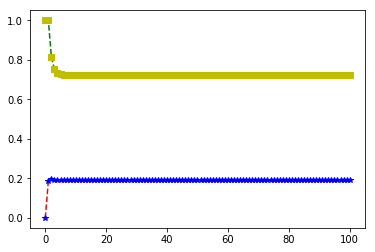

In [230]:
t = range(0,101)
plt.plot(t,u1vec, 'r--',u2vec,'b*', r1vec, 'g--', r2vec, "ys")


In [14]:
u1,u2,bu,x1, x2, bx, y1, y2, by, r1,r2,p = sp.symbols('u1,u2,bu,x1,x2,bx,y1,y2,by,r1,r2,p', real = True)
phi = p*(1 - p)*(2*p -1)
simplify(phi.subs([(p,u1)]) + phi.subs([(p,u2)]) - phi.subs([(p,u1+u2)]))

6*u1*u2*(u1 + u2 - 1)

In [46]:
d = -1
dprime = d + deltad if d>0 else deltad
dprime

0.05

In [67]:
x = a,b = [1,2]
x = 1,2
x

(1, 2)

In [171]:
x = [0,1]
y = [1,0]
for vec in (x,y):
    vec[1] = 2
x

[0, 2]

In [5]:
a11, a12, a14, a15, a21, a22, a24,a25, a31,a32,a34,a35,a41,a44,a52,a55 = sp.symbols('a11, a12, a14, a15, a21, a22, a24, a25, a31,a32,a34,a35,a41,a44,a52,a55', real = True)
J = sp.Matrix([[a11,a12,0,a14,a15],[a21, a22,0, a24,a25],[a31,a32,0,a34,a35],[a41,0,0,a44,0],[0,a52,0,0,a55]])
J.eigenvals()


{Piecewise((a11/4 + a22/4 + a44/4 + a55/4 - sqrt(-2*a11*a22/3 - 2*a11*a44/3 - 2*a11*a55/3 + 2*a12*a21/3 + 2*a14*a41/3 - 2*a22*a44/3 - 2*a22*a55/3 + 2*a25*a52/3 - 2*a44*a55/3 - 2*((a11*a22*a44*a55 - a11*a25*a44*a52 - a12*a21*a44*a55 + a12*a24*a41*a55 - a14*a22*a41*a55 + a14*a25*a41*a52 + a15*a21*a44*a52 - a15*a24*a41*a52 - (-a11 - a22 - a44 - a55)*(-a11*a22*a44/4 - a11*a22*a55/4 + a11*a25*a52/4 - a11*a44*a55/4 + a12*a21*a44/4 + a12*a21*a55/4 - a12*a24*a41/4 + a14*a22*a41/4 + a14*a41*a55/4 - a15*a21*a52/4 - a22*a44*a55/4 + a25*a44*a52/4 + (-a11 - a22 - a44 - a55)*(-a11*a22/16 - a11*a44/16 - a11*a55/16 + a12*a21/16 + a14*a41/16 - a22*a44/16 - a22*a55/16 + a25*a52/16 - a44*a55/16 + 3*(-a11 - a22 - a44 - a55)**2/256)))*(a11*a22 + a11*a44 + a11*a55 - a12*a21 - a14*a41 + a22*a44 + a22*a55 - a25*a52 + a44*a55 - 3*(-a11 - a22 - a44 - a55)**2/8)/3 - (a11*a22 + a11*a44 + a11*a55 - a12*a21 - a14*a41 + a22*a44 + a22*a55 - a25*a52 + a44*a55 - 3*(-a11 - a22 - a44 - a55)**2/8)**3/108 - (-a11*a22*a44 -

In [7]:
a,b,c = sp.symbols('a,b,c', real = True)
J = sp.Matrix([[a,a,a],[b,b,b],[c,c,c]])
J.eigenvals()

{a + b + c: 1, 0: 2}